<a href="https://colab.research.google.com/github/GonzaloMA-17/k_brazos_FJLGM/blob/main/notebook1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estudio comparativo de algoritmos en un problema de bandido de k-brazos

## Descripción del Problema

El problema del bandido de k-brazos es un clásico en el campo del aprendizaje por refuerzo. Consiste en un agente que debe elegir entre k opciones (brazos) en cada paso de tiempo, con el objetivo de maximizar la recompensa acumulada. Cada brazo proporciona recompensas según una distribución desconocida, y el agente debe aprender cuál es el mejor brazo a partir de la experiencia.

## Preparación del entorno

**Clonación del repositorio:**

Para poder acceder a todas las clases y métodos necesarios.

In [2]:
!git clone https://github.com/GonzaloMA-17/k_brazos_FJLGM.git

Cloning into 'k_brazos_FJLGM'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 69 (delta 25), reused 26 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (69/69), 354.11 KiB | 7.53 MiB/s, done.
Resolving deltas: 100% (25/25), done.


In [3]:
%cd k_brazos_FJLGM

/content/k_brazos_FJLGM


### Librerías

In [5]:
import numpy as np
from typing import List

from src_algorithms import Algorithm, EpsilonGreedy
from src_arms import ArmNormal, Bandit
from src_plotting import *

Semilla:

In [2]:
seed = 1234

**Definición del experimento:**

Cada algoritmo se ejecuta en un problema de k-armed bandit durante un número de pasos de tiempo y ejecuciones determinado. Se comparan los resultados de los algoritmos en términos de recompensa promedio.

Por ejemplo. Dado un bandido de k-brazos, se ejecutan dos algoritmos epsilon-greedy con diferentes valores de epsilon. Se estudia la evolución de cada política en un número de pasos, por ejemplo, mil pasos. Entonces se repite el experimento un número de veces, por ejemplo, 500 veces. Es decir, se ejecutan 500 veces la evolución de cada algoritmo en 1000 pasos. Para cada paso calculamos el promedio de las recoponensas obtenidas en esas 500 veces.

In [3]:
def run_experiment_with_regret(bandit: Bandit, algorithms: List[Algorithm], steps: int, runs: int):
    optimal_arm = bandit.optimal_arm
    optimal_reward = bandit.arms[optimal_arm].mu  # Obtener la recompensa esperada del brazo óptimo

    rewards = np.zeros((len(algorithms), steps))  # Matriz para almacenar las recompensas promedio.
    optimal_selections = np.zeros((len(algorithms), steps))  # Matriz para almacenar el porcentaje de selecciones óptimas.
    arm_rewards = np.zeros((len(algorithms), bandit.k))  # Matriz para almacenar las recompensas acumuladas por brazo.
    arm_counts = np.zeros((len(algorithms), bandit.k))  # Matriz para almacenar el número de selecciones por brazo.
    regret_accumulated = np.zeros((len(algorithms), steps))  # Matriz para almacenar el rechazo acumulado.

    np.random.seed(seed)  # Asegurar reproducibilidad de resultados.

    for run in range(runs):
        current_bandit = Bandit(arms=bandit.arms)

        for algo in algorithms:
            algo.reset()  # Reiniciar los valores de los algoritmos.

        for step in range(steps):
            for idx, algo in enumerate(algorithms):
                chosen_arm = algo.select_arm()  # Seleccionar un brazo según la política del algoritmo.
                reward = current_bandit.pull_arm(chosen_arm)  # Obtener la recompensa del brazo seleccionado.
                algo.update(chosen_arm, reward)  # Actualizar el valor estimado del brazo seleccionado.

                rewards[idx, step] += reward  # Acumular la recompensa obtenida en la matriz rewards para el algoritmo idx en el paso step.
                arm_rewards[idx, chosen_arm] += reward  # Acumular la recompensa obtenida en arm_rewards para el brazo chosen_arm.
                arm_counts[idx, chosen_arm] += 1  # Incrementar el conteo de selecciones para el brazo chosen_arm.

                # Modificar optimal_selections cuando el brazo elegido se corresponda con el brazo óptimo optimal_arm
                if chosen_arm == optimal_arm:
                    optimal_selections[idx, step] += 1

                # Calcular el rechazo acumulado
                regret_accumulated[idx, step] += optimal_reward - reward

    rewards /= runs

    # Calcular el porcentaje de selecciones óptimas y almacenar en optimal_selections
    optimal_selections = (optimal_selections / runs) * 100

    # Calcular el promedio de ganancias de cada brazo
    average_rewards = arm_rewards / np.maximum(arm_counts, 1)

    # Calcular el rechazo acumulado promedio
    regret_accumulated = np.cumsum(regret_accumulated, axis=1) / runs

    # Preparar las estadísticas de los brazos
    arm_stats = [{'average_rewards': average_rewards[idx], 'selection_counts': arm_counts[idx]} for idx in range(len(algorithms))]

    return rewards, optimal_selections, arm_stats, regret_accumulated

In [16]:
def run_experiment_modified(bandit: Bandit, algorithms: List[Algorithm], steps: int, runs: int):
    optimal_arm = bandit.optimal_arm  # Necesario para calcular el porcentaje de selecciones óptimas.

    rewards = np.zeros((len(algorithms), steps))  # Matriz para almacenar las recompensas promedio.
    optimal_selections = np.zeros((len(algorithms), steps))  # Matriz para almacenar el porcentaje de selecciones óptimas.
    arm_rewards = np.zeros((len(algorithms), bandit.k))  # Matriz para almacenar las recompensas acumuladas por brazo.
    arm_counts = np.zeros((len(algorithms), bandit.k))  # Matriz para almacenar el número de selecciones por brazo.
    selections_per_algorithm = np.zeros((len(algorithms), bandit.k))  # Matriz para contar selecciones por brazo.
    np.random.seed(seed)  # Asegurar reproducibilidad de resultados.

    for run in range(runs):
        current_bandit = Bandit(arms=bandit.arms)

        for algo in algorithms:
            algo.reset()  # Reiniciar los valores de los algoritmos.

        for step in range(steps):
            for idx, algo in enumerate(algorithms):
                chosen_arm = algo.select_arm()  # Seleccionar un brazo según la política del algoritmo.
                reward = current_bandit.pull_arm(chosen_arm)  # Obtener la recompensa del brazo seleccionado.
                algo.update(chosen_arm, reward)  # Actualizar el valor estimado del brazo seleccionado.

                rewards[idx, step] += reward  # Acumular la recompensa obtenida en la matriz rewards para el algoritmo idx en el paso step.
                selections_per_algorithm[idx, chosen_arm] += 1
                arm_rewards[idx, chosen_arm] += reward  # Acumular la recompensa obtenida en arm_rewards para el brazo chosen_arm.
                arm_counts[idx, chosen_arm] += 1  # Incrementar el conteo de selecciones para el brazo chosen_arm.

                # Modificar optimal_selections cuando el brazo elegido se corresponda con el brazo óptimo optimal_arm
                if chosen_arm == optimal_arm:
                    optimal_selections[idx, step] += 1

    rewards /= runs

    # Calcular el porcentaje de selecciones óptimas y almacenar en optimal_selections
    optimal_selections = (optimal_selections / runs) * 100

    # Imprimir la cantidad de veces que se seleccionó cada brazo
    print("\nNúmero de veces que fue seleccionado cada brazo:")

    for algo_idx, algo in enumerate(algorithms):
        print(f"\n- Algoritmo {algo_idx} (ε={algo.epsilon}):")
        for arm in range(bandit.k):
            status = "✅ Brazo Óptimo General" if arm == optimal_arm else "No óptimo"
            print(f"   Brazo {arm + 1}: {int(selections_per_algorithm[algo_idx, arm])} veces ({status})")

    # Calcular el promedio de ganancias de cada brazo
    average_rewards = arm_rewards / np.maximum(arm_counts, 1)

    # Preparar las estadísticas de los brazos
    arm_stats = [{'average_rewards': average_rewards[idx], 'selection_counts': arm_counts[idx]} for idx in range(len(algorithms))]

    return rewards, optimal_selections, arm_stats

In [ ]:
def run_experiment(bandit: Bandit, algorithms: List[Algorithm], steps: int, runs: int):

    optimal_arm = bandit.optimal_arm  # Necesario para calcular el porcentaje de selecciones óptimas.

    rewards = np.zeros((len(algorithms), steps)) # Matriz para almacenar las recompensas promedio.

    optimal_selections = np.zeros((len(algorithms), steps))  # Matriz para almacenar el porcentaje de selecciones óptimas.

    np.random.seed(seed)  # Asegurar reproducibilidad de resultados.

    for run in range(runs):
        current_bandit = Bandit(arms=bandit.arms)

        for algo in algorithms:
            algo.reset() # Reiniciar los valores de los algoritmos.

        total_rewards_per_algo = np.zeros(len(algorithms)) # Acumulador de recompensas por algoritmo. Necesario para calcular el promedio.

        for step in range(steps):
            for idx, algo in enumerate(algorithms):
                chosen_arm = algo.select_arm() # Seleccionar un brazo según la política del algoritmo.
                reward = current_bandit.pull_arm(chosen_arm) # Obtener la recompensa del brazo seleccionado.
                algo.update(chosen_arm, reward) # Actualizar el valor estimado del brazo seleccionado.

                rewards[idx, step] += reward # Acumular la recompensa obtenida en la matriz rewards para el algoritmo idx en el paso step.
                total_rewards_per_algo[idx] += reward # Acumular la recompensa obtenida en total_rewards_per_algo para el algoritmo idx.

                # Modificar optimal_selections cuando el brazo elegido se corresponda con el brazo óptimo optimal_arm
                if chosen_arm == optimal_arm:
                    optimal_selections[idx, step] += 1

    rewards /= runs

    # Calcular el porcentaje de selecciones óptimas y almacenar en optimal_selections
    optimal_selections = (optimal_selections / runs) * 100



    return rewards, optimal_selections


**Ejecución del experimento**:

Se realiza el experimento usando 10 brazos, cada uno de acuerdo a una distribución gaussina con desviación 1. Se realizan 500 ejecuciones de 1000 pasos cada una. Se contrastan 3 algoritmos epsilon greedy para valores epsilon: 0.0, 0.01, y 0.1.

In [4]:
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmNormal.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 3 algoritmos epsilon-greedy con diferentes valores de epsilon.
algorithms = [EpsilonGreedy(k=k, epsilon=0), EpsilonGreedy(k=k, epsilon=0.01), EpsilonGreedy(k=k, epsilon=0.1)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, armStats, regret = run_experiment_with_regret(bandit, algorithms, steps, runs)

Bandit with 10 arms: ArmNormal(mu=2.72, sigma=1.0), ArmNormal(mu=3.45, sigma=1.0), ArmNormal(mu=4.94, sigma=1.0), ArmNormal(mu=3.49, sigma=1.0), ArmNormal(mu=6.6, sigma=1.0), ArmNormal(mu=8.07, sigma=1.0), ArmNormal(mu=8.02, sigma=1.0), ArmNormal(mu=8.22, sigma=1.0), ArmNormal(mu=9.62, sigma=1.0), ArmNormal(mu=8.88, sigma=1.0)
Optimal arm: 9 with expected reward=9.62


**Visualización de resultados**:

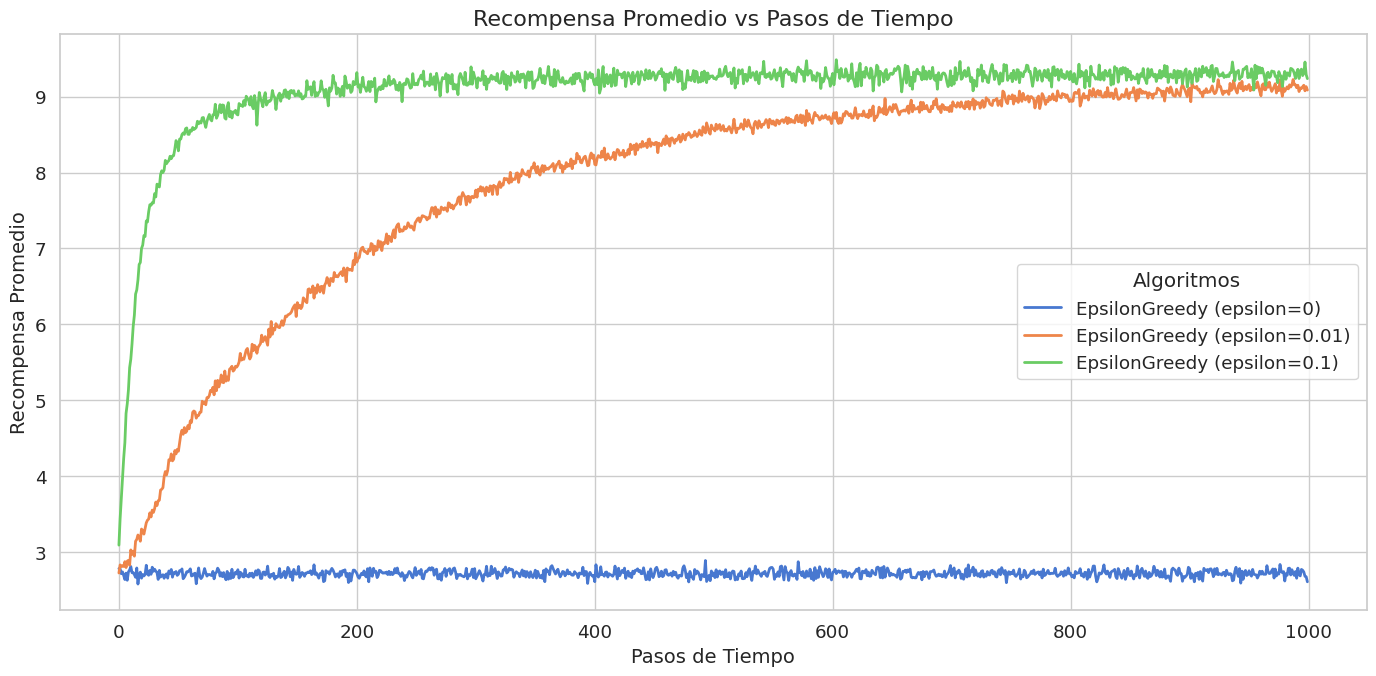

In [13]:
# Graficar los resultados
plot_average_rewards(steps, rewards, algorithms)
# plot_optimal_selections(steps, optimal_selections, algorithms)

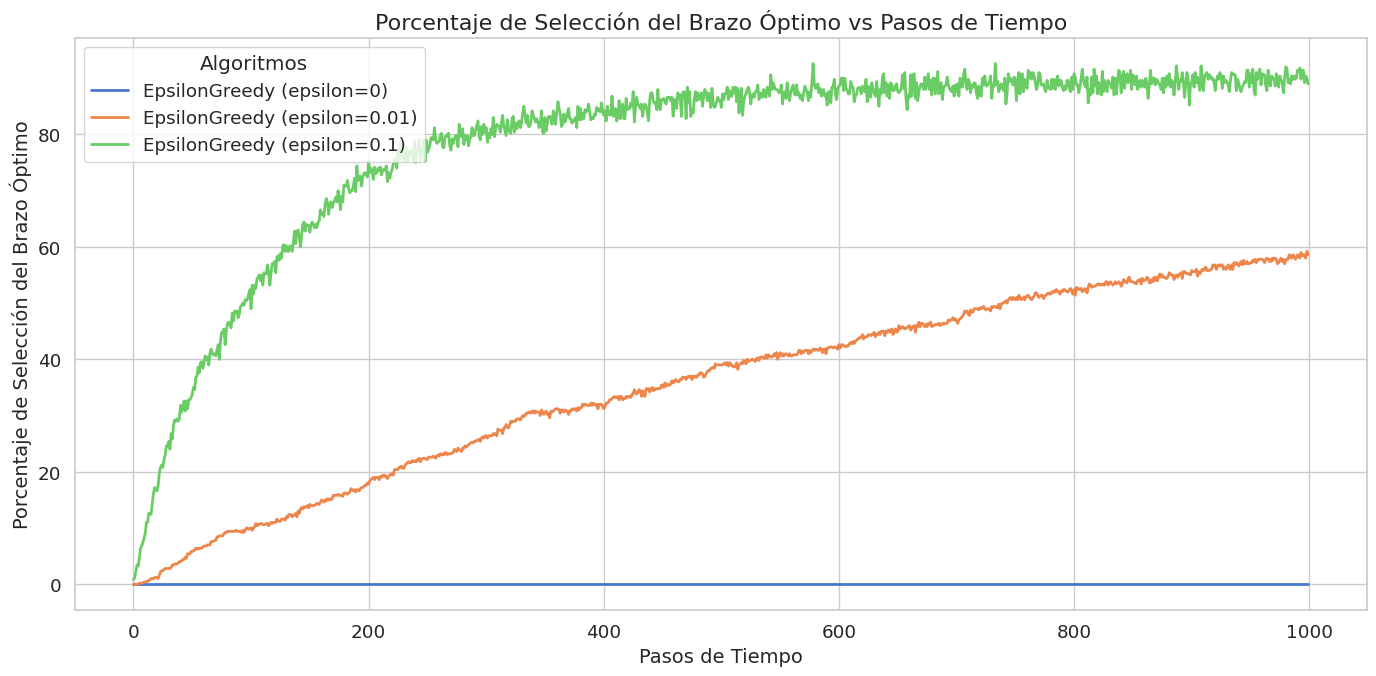

In [14]:
plot_optimal_selections(steps, optimal_selections, algorithms)

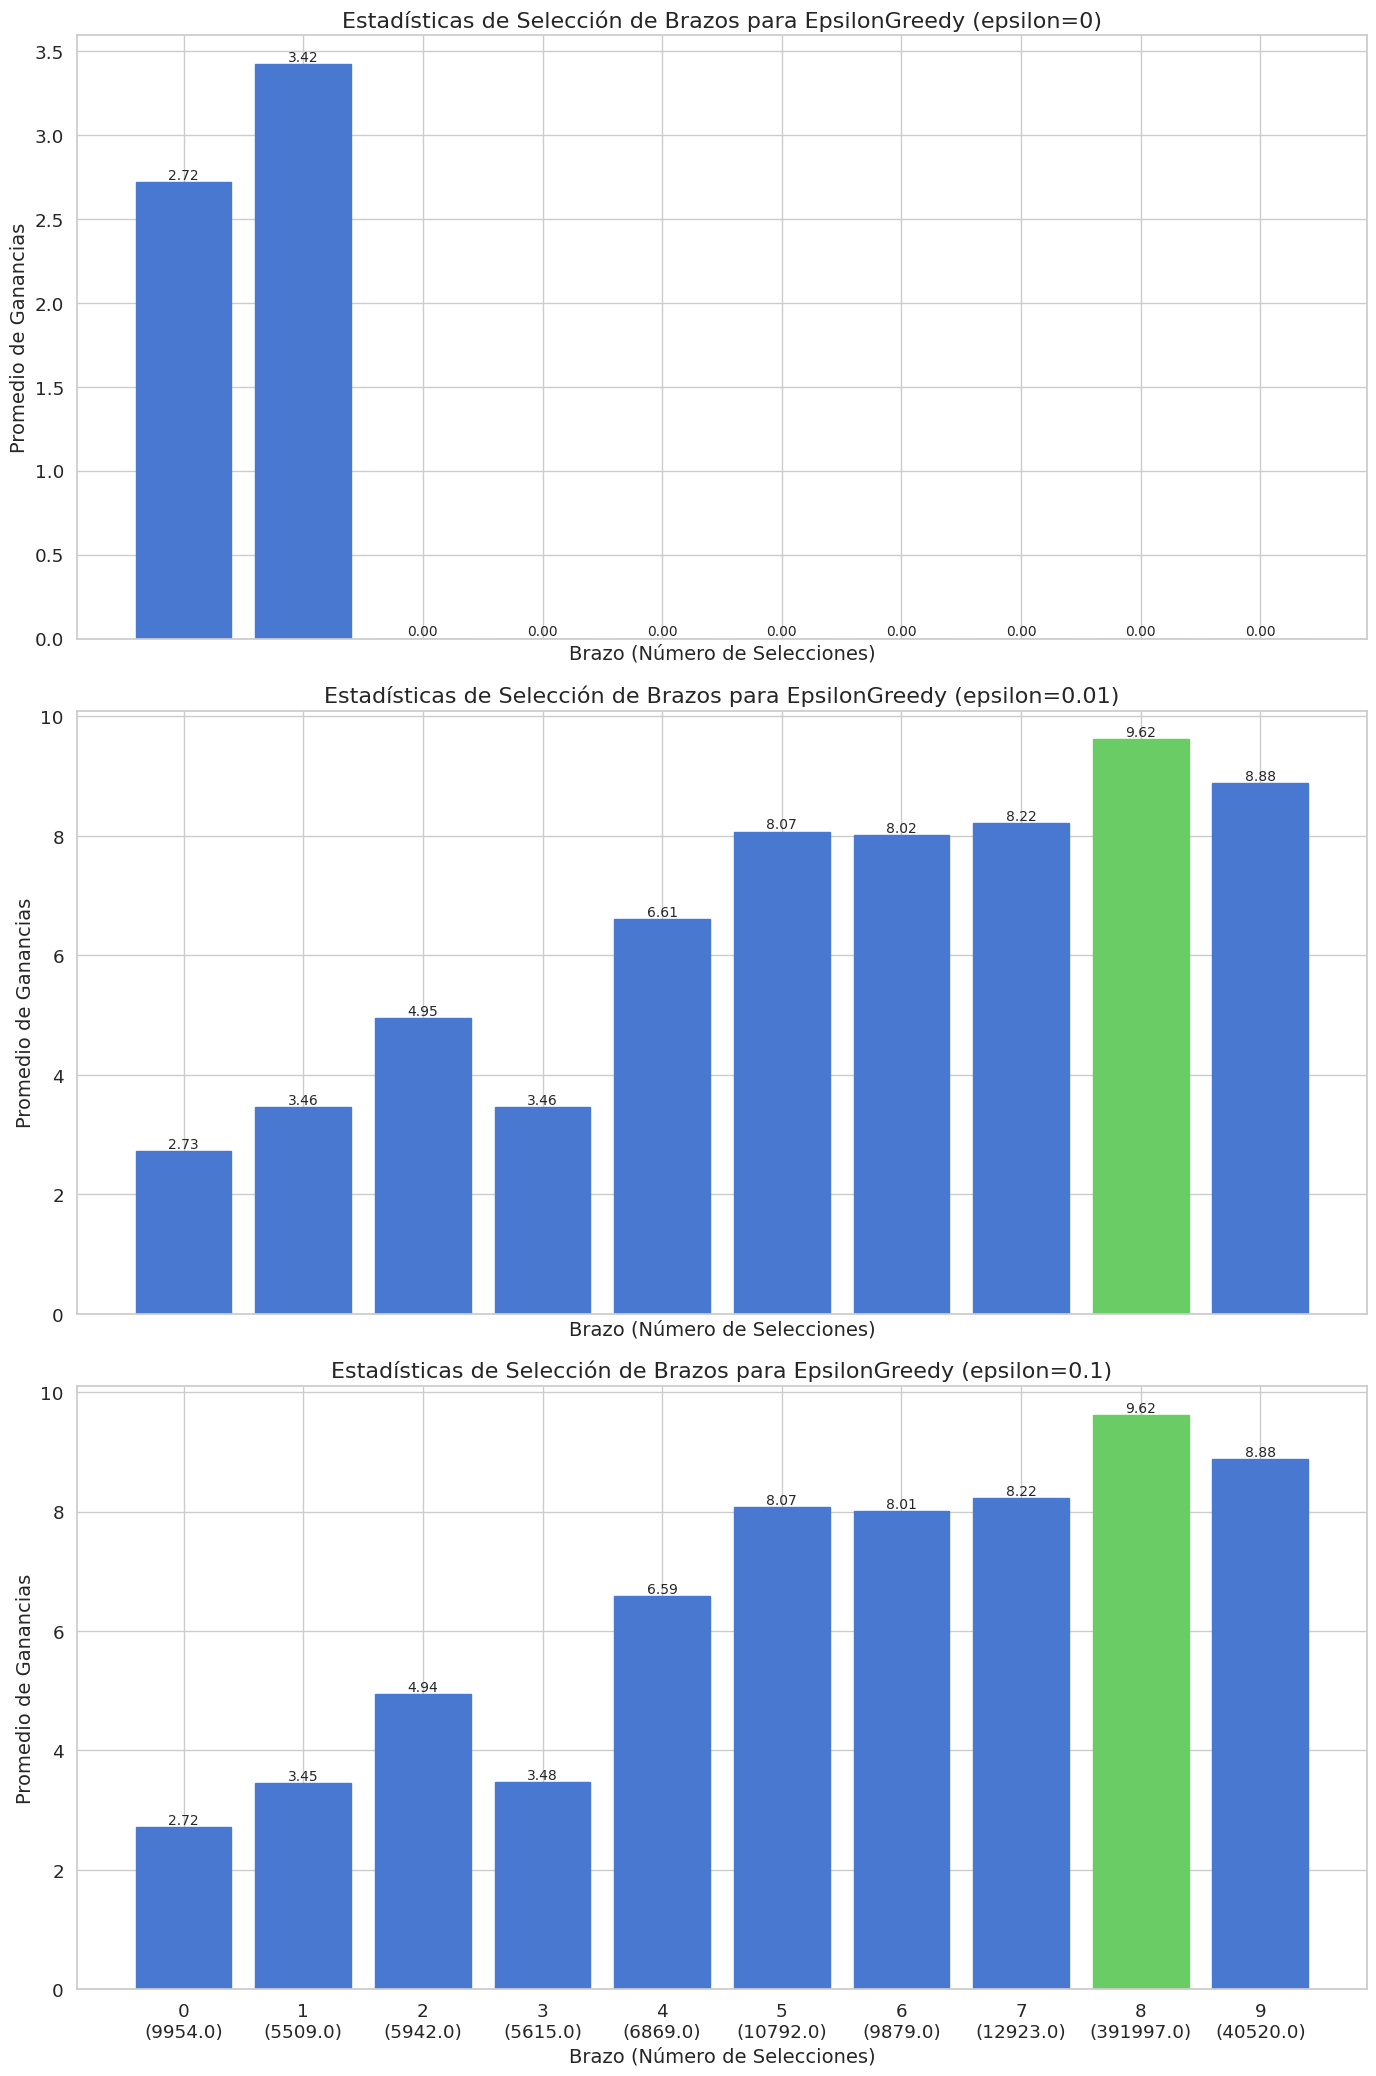

In [15]:
plot_arm_statistics(armStats, algorithms, optimal_arm)

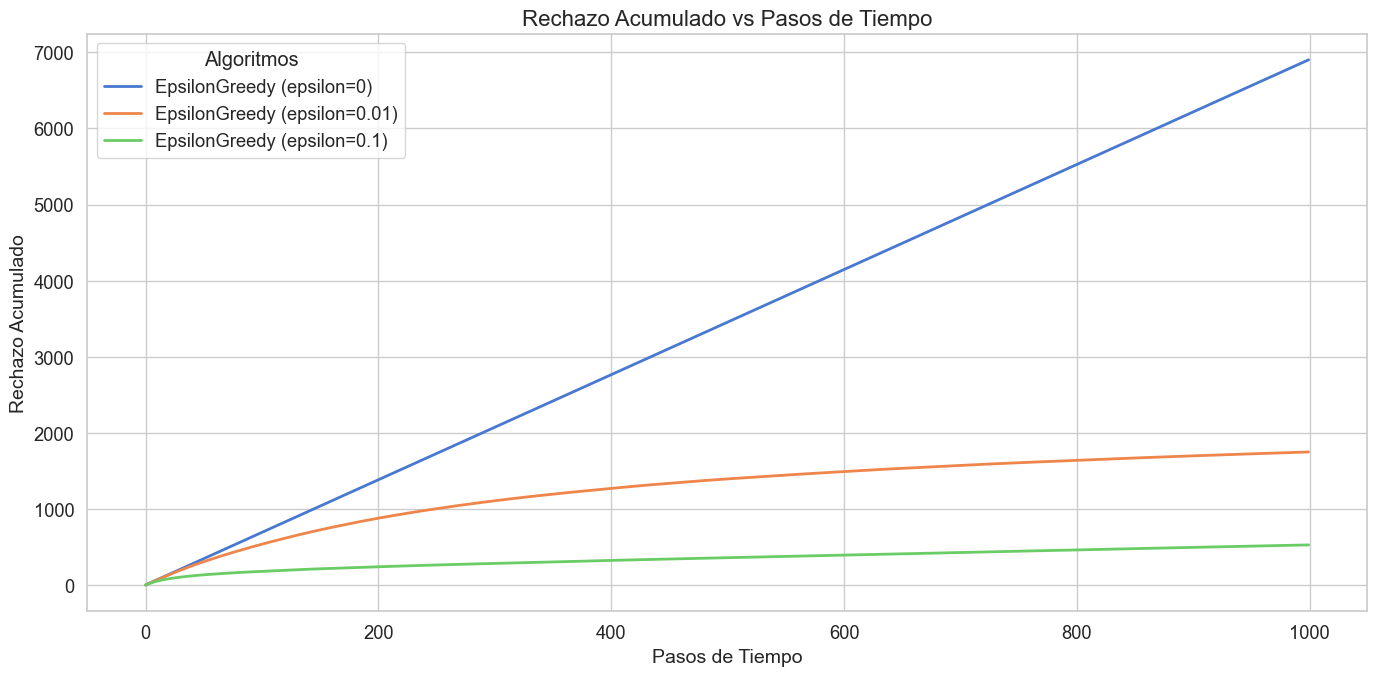

In [6]:
plot_regret(steps, regret, algorithms)

**Análisis detallado de la imagen**

La imagen muestra un gráfico de líneas titulado "Recompensa Promedio vs Pasos de Tiempo", donde se analiza el desempeño de diferentes estrategias del algoritmo ε-Greedy en un entorno de multi-armed bandit. En el eje x se representan los pasos de tiempo, mientras que en el eje y se muestra la recompensa promedio obtenida por cada algoritmo.

Tres líneas de colores distintos representan diferentes valores de ε en el algoritmo ε-Greedy:

- Azul (ε = 0): Representa una estrategia completamente explotadora, es decir, que siempre elige la acción que ha dado la mejor recompensa hasta ahora sin explorar nuevas opciones.
- Naranja (ε = 0.01): Representa una estrategia con una pequeña probabilidad del 1% de elegir una acción aleatoria (exploración).
- Verde (ε = 0.1): Representa una estrategia con un 10% de probabilidad de explorar acciones aleatorias.

**Crecimiento de la recompensa promedio:**

La línea verde (ε=0.1) alcanza rápidamente una recompensa promedio alta, lo que indica que la estrategia con mayor exploración aprende más rápido qué brazos del bandit son óptimos.
La línea naranja (ε=0.01) también muestra un crecimiento, pero más lento en comparación con ε=0.1.
La línea azul (ε=0) se mantiene en un nivel bajo de recompensa, lo que sugiere que no logra encontrar el mejor brazo porque no explora nuevas opciones.

**Conclusiones**

Hemos estudiado un experimento de toma de decisiones secuenciales, modelado con un Multi-Armed Bandit (MAB). Este problema es fundamental en el aprendizaje por refuerzo y la teoría de decisiones. La idea principal es que un agente debe aprender cuál es la mejor acción (brazo del bandit) a partir de la experiencia acumulada. Para este estudio nos hemos centrado solo en el estudio del algoritmo epsilon-greedy, llegando a las siguientes conclusiones a partir de los resultados obtenidos y la gráfica generada:

1. Exploración vs Explotación

El algoritmo ε-Greedy equilibra la exploración y la explotación:

Explotación (ε=0): Siempre elige la mejor opción conocida, pero si inicialmente se selecciona un brazo subóptimo, nunca descubrirá otras opciones más rentables.
Exploración (ε>0): Introduce aleatoriedad en la selección de acciones para descubrir nuevas opciones potencialmente mejores.
El gráfico confirma este comportamiento:

ε=0.1 (verde) obtiene la mejor recompensa promedio a lo largo del tiempo porque explora lo suficiente como para encontrar rápidamente el mejor brazo.
ε=0.01 (naranja) explora menos, por lo que tarda más en converger a una recompensa alta.
ε=0 (azul) no explora en absoluto y queda atrapado en una recompensa subóptima.

2. Convergencia de los algoritmos

Los algoritmos con mayor exploración (ε=0.1) alcanzan una recompensa alta más rápido. Esto se debe a que:

Al principio, el algoritmo no tiene información suficiente sobre cuál es el mejor brazo.
Con el tiempo, al realizar exploraciones, descubre cuál es el mejor brazo y empieza a explotarlo más.
Un balance entre exploración y explotación es clave para maximizar la recompensa a largo plazo.

3. Aplicaciones y conclusiones

En problemas de toma de decisiones (ejemplo: recomendaciones, optimización de anuncios, medicina personalizada), una estrategia de exploración moderada como ε=0.1 es más efectiva para encontrar la mejor opción rápidamente.
La falta de exploración (ε=0) lleva a un desempeño deficiente, ya que el agente puede quedarse atrapado en una elección subóptima.
En conclusión, el gráfico muestra cómo un nivel adecuado de exploración mejora significativamente el rendimiento del algoritmo en un entorno de aprendizaje por refuerzo. 🚀